In [ ]:
import numpy as np 
import pandas as pd 
import cv2 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import keras
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Add, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adadelta, Adam, SGD
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import load_model
import itertools
import warnings
warnings.filterwarnings('ignore')

# Pre-processing

## Building a dataframe

> We build a dataframe containing the image filepaths and their corresponding label.

In [ ]:
# find all the files with the PNG extension
full_path = glob.glob('/content/drive/MyDrive/COVID-19 Radiography Database/*/*.png')
# extract the image label
class_name = [re.findall(r'([\w\s-]+)', i)[-4] for i in full_path]
# Build a dataframe
df = pd.DataFrame(data = np.stack([np.array(full_path), np.array(class_name)], axis = 1), columns = ['img_paths', 'label'])
df.head()

,img_paths,label
0,/content/drive/MyDrive/COVID-19 Radiography Da...,COVID-19
1,/content/drive/MyDrive/COVID-19 Radiography Da...,COVID-19
2,/content/drive/MyDrive/COVID-19 Radiography Da...,COVID-19
3,/content/drive/MyDrive/COVID-19 Radiography Da...,COVID-19
4,/content/drive/MyDrive/COVID-19 Radiography Da...,COVID-19


## Train / Test split

> The data will be split into two parts :
>- Training set : 80%
>- Test set : 20%

In [ ]:
df_train, df_test = train_test_split(df,
                                     test_size = 0.2,
                                     stratify = df.label,
                                     random_state = 42)

In [ ]:
print('Training data shape:', df_train.shape)
print('Test data shape:', df_test.shape)

Training data shape: (2324, 2)
Test data shape: (581, 2)


In [ ]:
print('Normal images count in training set:', df_train.img_paths.str.contains('NORMAL').sum())
print('COVID-19 images count in training set:', df_train.img_paths.str.contains('/COVID-19/').sum())
print('Viral Pneumonia images count in training set:', df_train.img_paths.str.contains('Viral Pneumonia').sum())

Normal images count in training set: 1073
COVID-19 images count in training set: 175
Viral Pneumonia images count in training set: 1076


# Data Augmentation

> Data augmentation is a method often applied in Deep Learning to generate a number of samples required.
>
> It enhances the effectiveness of the neural network for a small databases by optimizing it.
>
> Furthemore, our dataset is imbalanced, so applying some image augmentation techniques will aim to artificially increase the size of the training data.

In [ ]:
datagen_train = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   zoom_range = [0.9, 1.1],
                                   width_shift_range = [-0.1, 0.1],
                                   height_shift_range = [-0.1, 0.1],
                                   horizontal_flip = True)

datagen_val = ImageDataGenerator(rescale = 1./255.,
                                 rotation_range = 10,
                                 zoom_range = [0.9, 1.1],
                                 width_shift_range = [-0.1, 0.1],
                                 height_shift_range = [-0.1, 0.1])

In [ ]:
train_generator = datagen_train.flow_from_dataframe(dataframe = df_train,
                                                    directory = None,
                                                    x_col = 'img_paths',
                                                    y_col = 'label',
                                                    class_mode = 'categorical',
                                                    batch_size = 32,
                                                    shuffle = False,
                                                    subset = 'training')

test_generator = datagen_val.flow_from_dataframe(dataframe = df_test,
                                                 directory = None,
                                                 x_col = 'img_paths',
                                                 y_col = 'label',
                                                 class_mode = 'categorical',
                                                 batch_size = 32,
                                                 shuffle = False)

Found 2324 validated image filenames belonging to 3 classes.
Found 581 validated image filenames belonging to 3 classes.


# Model Building

In [ ]:
batch_size = 32
learning_rate = 0.001

## Custom metrics

> We define the F1-score metric by defining the recall and precision metric function.

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
METRICS = ['accuracy', AUC(name = 'auc'), f1_m]

## Architecture

> Our model is built using the transfer learning technique. The base model is a pre-trained VGG16 model on ImageNet and the classification part consists of three Dense layers with ReLU activation layer followed by a Dropout layer for regularization with a rate of 0.5. Finally, the output layer consists of 3 neurons, each neuron for a class, and a softmax activation function.

In [ ]:
num_classes = 3

base_model = VGG16(
    include_top = False, # Do not include the ImageNet classifier at the top.
    weights = "imagenet", # Load weights pre-trained on ImageNet.
    input_shape = (224, 224, 3)
)

# Freeze the base_model
base_model.trainable = False

output_model = base_model.output
output_model = GlobalAveragePooling2D()(output_model)
output_model = Flatten()(output_model)
output_model = Dense(256, activation = 'relu')(output_model) #adding a new dense 256 layer w/ a .5 dropout
output_model = Dropout(0.5)(output_model)
output_model = Dense(128, activation = 'relu')(output_model) #adding a new dense 128 layer w/ a .5 dropout
output_model = Dropout(0.5)(output_model)
output_model = Dense(64, activation = 'relu')(output_model)
output_model = Dropout(0.5)(output_model)
output_model = Dense(num_classes, activation = 'softmax', name = 'visualized_layer')(output_model)

final_model = Model(inputs = base_model.input, outputs = output_model)

final_model.compile(optimizer = Adam(lr = learning_rate),
                    loss = 'categorical_crossentropy',
                    metrics = METRICS)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Fitting the model

> We define class weights to put more emphasis on the imbalanced class during the training phase.

In [ ]:
# covid_19_count = df['COVID-19'].sum()
# normal_count = df['NORMAL'].sum()
# viral_count = df['VIRAL_PNEUMONIA'].sum()

# print('COVID-19 images count', covid_19_count)
# print('NORMAL images count', normal_count)
# print('Viral Pneumonia images count', viral_count)

In [ ]:
covid_19_count = df[df.label == 'COVID-19'].shape[0]
normal_count = df[df.label == 'NORMAL'].shape[0]
viral_count = df[df.label == 'Viral'].shape[0]

print('COVID-19 images count', covid_19_count)
print('NORMAL images count', normal_count)
print('Viral Pneumonia images count', viral_count)

COVID-19 images count 219
NORMAL images count 1341
Viral Pneumonia images count 1345


In [ ]:
total_wt = df.shape[0]

weights = {
    0: 0.5 * (1 - covid_19_count/total_wt),
    1: 0.5 * (1 - normal_count/total_wt),
    2: 0.5 * (1 - viral_count/total_wt)
}
print(weights)

{0: 0.46230636833046473, 1: 0.2691910499139415, 2: 0.2685025817555938}


In [ ]:
history = final_model.fit_generator(generator = train_generator,
                                    class_weight = weights,
                                    steps_per_epoch = df_train.shape[0] // batch_size,
                                    validation_data = test_generator,
                                    validation_steps = df_test.shape[0] // batch_size,
                                    epochs = 20)

Epoch 1/20
72/72 [==============================] - 1819s 25s/step - loss: 0.3111 - accuracy: 0.4664 - auc: 0.6554 - f1_m: 0.3377 - val_loss: 0.8145 - val_accuracy: 0.6562 - val_auc: 0.8628 - val_f1_m: 0.5242
Epoch 2/20
72/72 [==============================] - 94s 1s/step - loss: 0.2416 - accuracy: 0.6566 - auc: 0.8216 - f1_m: 0.5359 - val_loss: 0.5467 - val_accuracy: 0.8247 - val_auc: 0.9301 - val_f1_m: 0.8095
Epoch 3/20
72/72 [==============================] - 94s 1s/step - loss: 0.1831 - accuracy: 0.7893 - auc: 0.9079 - f1_m: 0.7723 - val_loss: 0.4829 - val_accuracy: 0.8212 - val_auc: 0.9390 - val_f1_m: 0.8192
Epoch 4/20
72/72 [==============================] - 93s 1s/step - loss: 0.1638 - accuracy: 0.8216 - auc: 0.9301 - f1_m: 0.8177 - val_loss: 0.4069 - val_accuracy: 0.8403 - val_auc: 0.9542 - val_f1_m: 0.8412
Epoch 5/20
72/72 [==============================] - 93s 1s/step - loss: 0.1494 - accuracy: 0.8318 - auc: 0.9399 - f1_m: 0.8212 - val_loss: 0.3726 - val_accuracy: 0.8559 - va

In [ ]:
# final_model.save('/content/drive/MyDrive/vgg16_first_model.h5')

# Evaluation of the model

> We define two functions for evaluating the model.
>
>\
> The `display_history` function enables to plot the loss function, the accuracy, the f1_score and the AUC for the training and validation set. Its only argument is the history of the model.
>
>\
> The `plot_confusion_matrix` function enables to plot a beautiful version of the confusion matrix with a heatmap. Its main arguments are :
> - cm : confusion matrix
> - classes : the class labels (COVID-19, Normal, Viral Pneumonia)
>
> The output is a normalized confusion matrix regarding the recalls. In other words, only the recalls for each class is shown.

In [ ]:
def display_history(history_):
    fig, ax = plt.subplots(1, 4, figsize = (20, 10))
    ax[0].plot(history_.history['loss'], color = 'b', label = "training_loss")
    ax[0].plot(history_.history['val_loss'], color = 'r', label = "validation_loss", axes = ax[0])
    legend = ax[0].legend(loc = 'best', shadow = True)

    ax[1].plot(history_.history['accuracy'], color = 'b', label = "training_accuracy")
    ax[1].plot(history_.history['val_accuracy'], color = 'r', label = "validation_accuracy")
    legend = ax[1].legend(loc = 'best', shadow = True)

    ax[2].plot(history_.history['f1_m'], color = 'b', label = "training_f1_score")
    ax[2].plot(history_.history['val_f1_m'], color = 'r', label = "validation_f1_score")
    legend = ax[2].legend(loc = 'best', shadow = True)

    ax[3].plot(history_.history['auc'], color = 'b', label = "training_auc")
    ax[3].plot(history_.history['val_auc'], color = 'r', label = "validation_auc")
    legend = ax[3].legend(loc = 'best', shadow = True)

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
results = final_model.evaluate_generator(generator = test_generator, steps = df_test.shape[0] // batch_size)
for index, metric in enumerate(final_model.metrics_names):
  print(f'test_{metric} :',round(results[index]*100),'%')

test_loss : 21 %
test_accuracy : 92 %
test_auc : 99 %
test_f1_m : 92 %


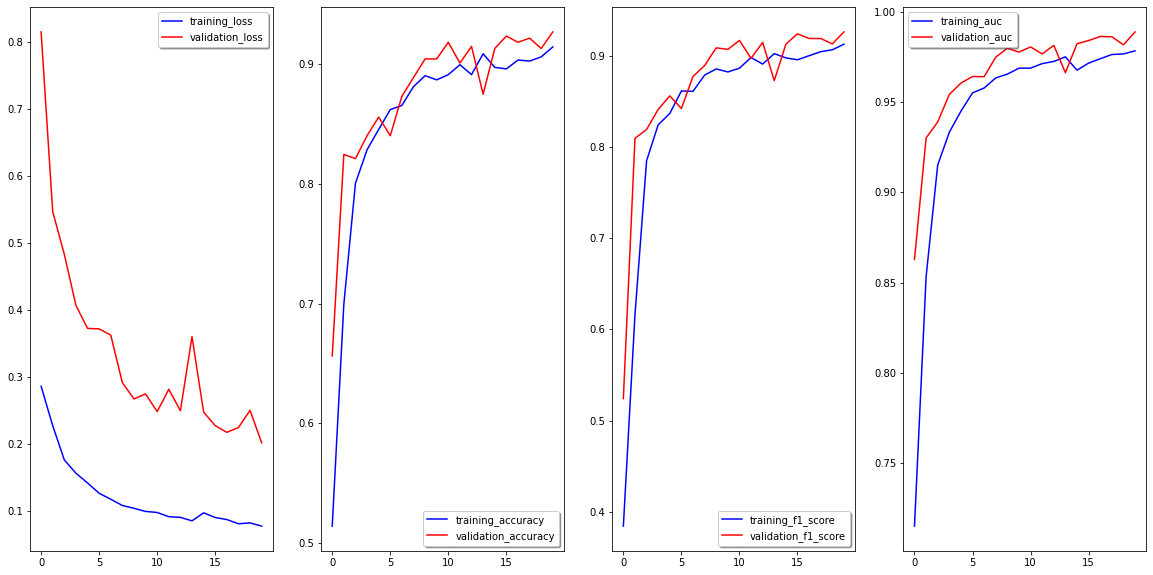

In [ ]:
display_history(history)

## Confusion matrix

In [ ]:
test_generator.reset() # the reset method allows us to not get the outputs in disorder
predictions = final_model.predict_generator(generator = test_generator)
y_test = test_generator.classes
y_pred = np.argmax(predictions, axis = -1)
class_names = test_generator.class_indices.keys()

> The `y_pred` array contains the predicted labels but since they are encoded, we can't tell which predicted encoded label corresponds to its predicted original (*categorical*) label.
>
> In the following cell, the `final_predictions` list maps the predicted labels with their uniques ID's (*i.e.* filenames `img_paths`).

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
final_predictions = [labels[k] for k in y_pred]

filenames = test_generator.filenames
results = pd.DataFrame({"img_paths":filenames,
                      "Predictions":final_predictions})

> We build a dataframe `results` that associates the predicted label to the image.

In [ ]:
results.head()

,img_paths,Predictions
0,/content/drive/MyDrive/COVID-19 Radiography Da...,Viral
1,/content/drive/MyDrive/COVID-19 Radiography Da...,NORMAL
2,/content/drive/MyDrive/COVID-19 Radiography Da...,Viral
3,/content/drive/MyDrive/COVID-19 Radiography Da...,NORMAL
4,/content/drive/MyDrive/COVID-19 Radiography Da...,NORMAL


In [ ]:
final_df_labels = df_test.merge(results, on = 'img_paths')
final_df_labels.head()

,img_paths,label,Predictions
0,/content/drive/MyDrive/COVID-19 Radiography Da...,Viral,Viral
1,/content/drive/MyDrive/COVID-19 Radiography Da...,NORMAL,NORMAL
2,/content/drive/MyDrive/COVID-19 Radiography Da...,Viral,Viral
3,/content/drive/MyDrive/COVID-19 Radiography Da...,NORMAL,NORMAL
4,/content/drive/MyDrive/COVID-19 Radiography Da...,NORMAL,NORMAL


> The `final_df_labels` is a merge between the `df_test` DataFrame with the ground truth labels and the `results` DataFrame with the predicted labels.

In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

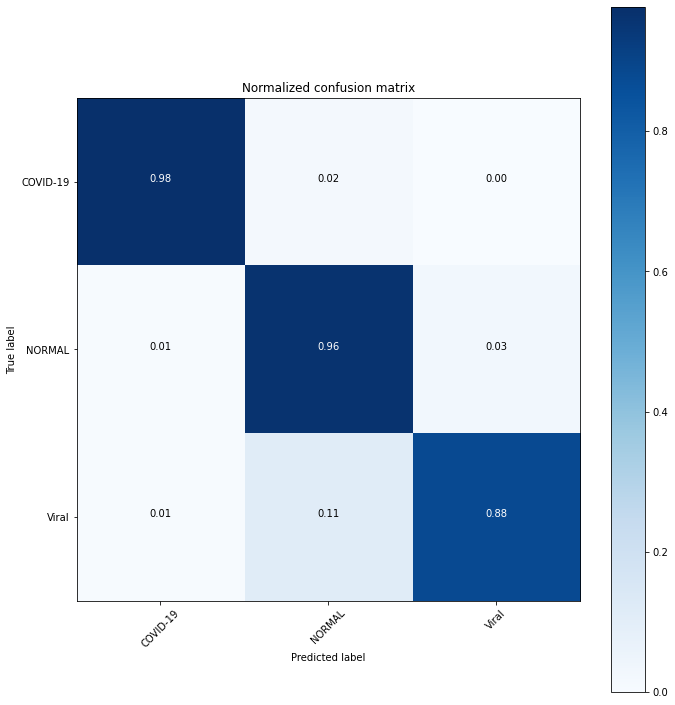

In [ ]:
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Normalized confusion matrix')
plt.show();

> This normalized confusion matrix represents the recalls of each category.
>
> As one can see, on the one hand the recalls for COVID-19 and Normal categories are almost perfect (respectively 98% and 96%), on the other hand the Viral Pneumonial category needs some improving since 12% of Viral Pneumonia images are predicted as Normal.

## Classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    COVID-19       0.91      0.98      0.95        44
      NORMAL       0.89      0.96      0.93       268
       Viral       0.97      0.88      0.92       269

    accuracy                           0.93       581
   macro avg       0.92      0.94      0.93       581
weighted avg       0.93      0.93      0.93       581



> The recalls for COVID-19 and Normal are higher than precision which is exactly what we would want because, in the medical field, we strive for getting the number of False Negatives as low as possible.
>
> Note that the f1-score for each category is greater than 90% which is a good result.

# Fine-tuning

## Architecture

In [ ]:
# We let the model train the 10 last layers of the VGG16 models
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [ ]:
# The 'lr_plateau' callback enables to change the learning_rate with respect to the accuracy metric on the test set
lr_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                               patience = 10,
                               verbose = 2,
                               mode = 'min')

In [ ]:
# Let's run again the model, decreasing the learning rate
final_model.compile(optimizer = Adam(lr = learning_rate/10),
                    loss = 'categorical_crossentropy',
                    metrics = METRICS)

## Fitting the fine-tuned model

In [ ]:
finetuned_history = final_model.fit_generator(generator = train_generator,
                                              class_weight = weights,
                                              steps_per_epoch = df_train.shape[0] // batch_size,
                                              validation_data = test_generator,
                                              validation_steps = df_test.shape[0] // batch_size,
                                              epochs = 30,
                                              callbacks = [lr_plateau])

Epoch 1/30
72/72 [==============================] - 99s 1s/step - loss: 0.3247 - accuracy: 0.7310 - auc: 0.9284 - f1_m: 0.7259 - val_loss: 0.2579 - val_accuracy: 0.8941 - val_auc: 0.9812 - val_f1_m: 0.8946
Epoch 2/30
72/72 [==============================] - 96s 1s/step - loss: 0.1169 - accuracy: 0.8726 - auc: 0.9642 - f1_m: 0.8713 - val_loss: 0.2451 - val_accuracy: 0.9132 - val_auc: 0.9837 - val_f1_m: 0.9120
Epoch 3/30
72/72 [==============================] - 96s 1s/step - loss: 0.0724 - accuracy: 0.9257 - auc: 0.9816 - f1_m: 0.9281 - val_loss: 0.2057 - val_accuracy: 0.9358 - val_auc: 0.9862 - val_f1_m: 0.9350
Epoch 4/30
72/72 [==============================] - 96s 1s/step - loss: 0.0685 - accuracy: 0.9284 - auc: 0.9835 - f1_m: 0.9299 - val_loss: 0.2161 - val_accuracy: 0.9219 - val_auc: 0.9854 - val_f1_m: 0.9190
Epoch 5/30
72/72 [==============================] - 96s 1s/step - loss: 0.0649 - accuracy: 0.9194 - auc: 0.9850 - f1_m: 0.9218 - val_loss: 0.2576 - val_accuracy: 0.9167 - val_a

## Evaluation of the fine-tuned model

In [ ]:
fine_tuned_results = final_model.evaluate_generator(generator = test_generator, steps = df_test.shape[0] // batch_size)
for index, metric in enumerate(final_model.metrics_names):
  print(f'test_{metric} :',round(fine_tuned_results[index]*100),'%')

test_loss : 14 %
test_accuracy : 96 %
test_auc : 99 %
test_f1_m : 96 %


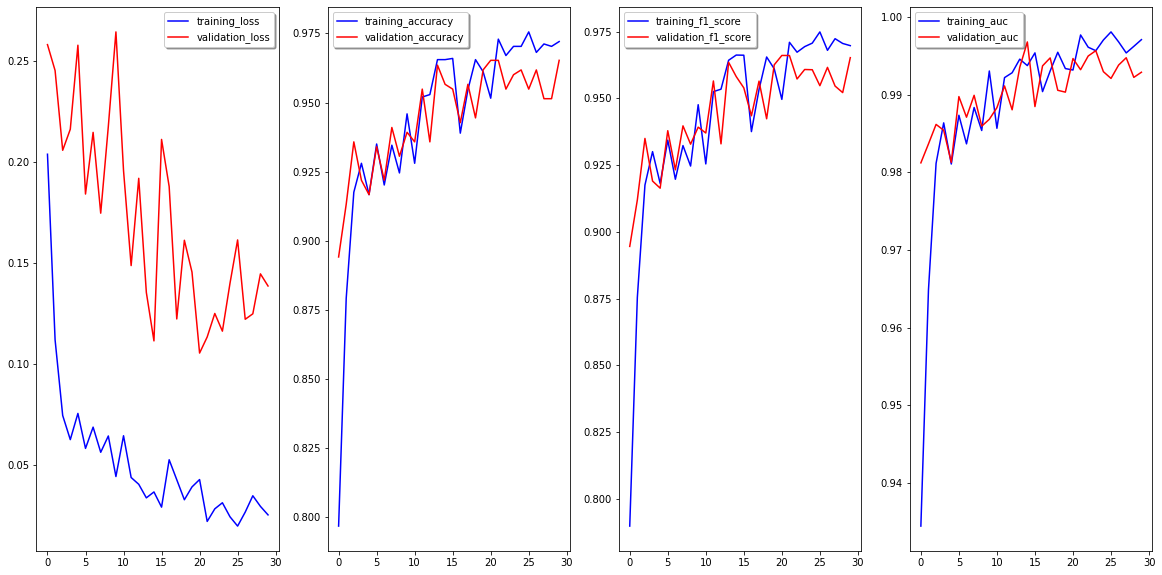

In [ ]:
display_history(finetuned_history)

### Confusion matrix

In [ ]:
test_generator.reset()
predictions = final_model.predict_generator(generator = test_generator)
y_test = test_generator.classes
y_pred = np.argmax(predictions, axis = -1)
class_names = test_generator.class_indices.keys()

In [ ]:
fine_labels = (train_generator.class_indices)
fine_labels = dict((v,k) for k,v in fine_labels.items())
fine_final_predictions = [fine_labels[k] for k in y_pred]

filenames = test_generator.filenames
fine_results = pd.DataFrame({"img_paths":filenames,
                             "Predictions":fine_final_predictions})

In [ ]:
fine_final_df_labels = df_test.merge(fine_results, on = 'img_paths')
fine_final_df_labels.head()

,img_paths,label,Predictions
0,/content/drive/MyDrive/COVID-19 Radiography Da...,Viral,Viral
1,/content/drive/MyDrive/COVID-19 Radiography Da...,NORMAL,NORMAL
2,/content/drive/MyDrive/COVID-19 Radiography Da...,Viral,Viral
3,/content/drive/MyDrive/COVID-19 Radiography Da...,NORMAL,NORMAL
4,/content/drive/MyDrive/COVID-19 Radiography Da...,NORMAL,NORMAL


In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

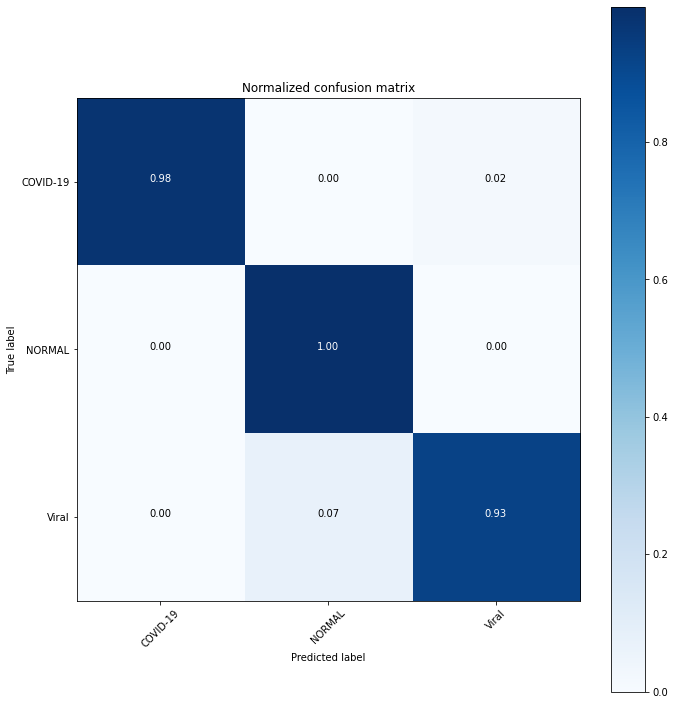

In [ ]:
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Normalized confusion matrix')
plt.show();

> We have a better recall for the Viral Pneumonia class (93%) than before tuning the model (88%).
> The Normal class is perfect, 100% recall which means that all of the 'normal' images are perfectly identified.

### Classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    COVID-19       0.98      0.98      0.98        44
      NORMAL       0.93      1.00      0.96       268
       Viral       0.99      0.93      0.96       269

    accuracy                           0.96       581
   macro avg       0.97      0.97      0.97       581
weighted avg       0.96      0.96      0.96       581



In [ ]:
# final_model.save('/content/drive/MyDrive/fine_tuned_vgg16_first_model.h5')